# Imports

In [64]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_recall_fscore_support
from scipy import interp
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import pickle
import matplotlib.pyplot as plt

# Setup and Data Examination


Read in data set


In [65]:
#Read in seeds csv file
df = pd.read_csv("./seeds.csv")

df.head()

,area,perimeter,compactness,length of kernel,width of kernel,asymmetry coefficient,length of kernel groove,type
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1


In [66]:
df['type'].value_counts()

3    70
2    70
1    70
Name: type, dtype: int64

From examining the different types of seeds we can see that there is an even ratio of seeds to eachother.As we are dealing with binary classification, we will have to change this type later in our program.

In [67]:
df.isna().sum()

area                       0
perimeter                  0
compactness                0
length of kernel           0
width of kernel            0
asymmetry coefficient      0
length of kernel groove    0
type                       0
dtype: int64

We do not have any missing values.

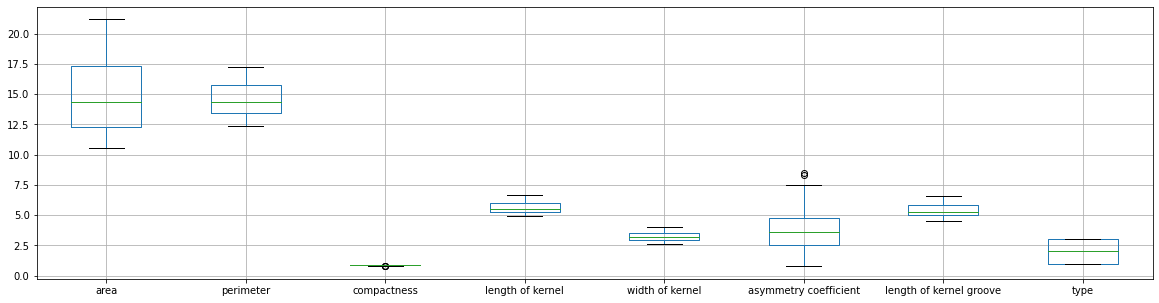

In [68]:
df.boxplot(figsize=(20,5))
plt.show()

From reviewing the plot we can conclude that the only outlier is present in asymmetry coefficient. Even though this outlier is not too big it is important to treat the outliers. For this I will be RobustScalar to deal with the outliers.

# Transormation to Binary

In [69]:
mapper = {1 : 1
           , 2 : 0,
           3: 0 }
df['type'] = df['type'].replace(mapper)


We then check the value counts in order to see how the transformation changed the data

In [70]:

df['type'].value_counts()

0    140
1     70
Name: type, dtype: int64

# Data Preprocessing

In [71]:
# store a list with the names of all predictors
names_all = [c for c in df if c not in ['type']]

# define column groups with same data preparation
names_outliers = ['asymmetry coefficient','compactness']
names_no_outliers = list(set(names_all) - set(names_outliers))

In [72]:
class AddColumnNames(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame(data=X, columns=self.columns)

In [73]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [74]:

preprocess_pipeline = make_pipeline(
    AddColumnNames(columns=names_all),
    FeatureUnion(transformer_list=[
        ("outlier_columns", make_pipeline(
            ColumnSelector(columns=names_outliers),
            FunctionTransformer(np.log, validate=True),
            RobustScaler()
        )),
        ("no_outlier_columns", make_pipeline(
            ColumnSelector(columns=names_no_outliers),
            StandardScaler()
        ))
    ])
)

In [75]:
y = df['type']
X = df.drop('type', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

Before feeding our data into the classifiers we spit the data into training and testing data. We split these at a ratio for 80/20%

# Classifiers



**SVM Classifier**

In [76]:
# create pipeline with SVM classifier
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('svm', svm.SVC(probability=True))])

#Different values for the parameters of SVM - Not an exhausted list.
param_grid = {
    'svm__C': [0.1, 1, 10, 50, 100, 200],  
    'svm__gamma': [1, 0.1, 0.01, 0.001], 
    'svm__kernel': ['rbf', 'linear', 'poly']}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
SVM_best_params = search.best_params_
SVM_best_model = search.best_estimator_

Best CV score = 0.970:
Best parameters:  {'svm__C': 200, 'svm__gamma': 1, 'svm__kernel': 'linear'}


**Random Forest Classifier**

In [77]:
# create pipeline with Random Forest Classifier
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('rf', RandomForestClassifier())])

#Different values for the parameters of Random Forest - not an exhausted list
param_grid = {
    'rf__n_estimators' : [10,15,20,30,50],
    'rf__max_depth': [2, 4, 6, 8, 10]
}

search = GridSearchCV(pipe, param_grid, cv=10, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.922:
Best parameters:  {'rf__max_depth': 6, 'rf__n_estimators': 30}


**KNN Classifier**

In [78]:
from sklearn.neighbors import KNeighborsClassifier
# create the pipeline
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), ('knn', KNeighborsClassifier())])

# prepare a prameter grid
param_grid = {
    'knn__weights' : ['uniform', 'distance'],
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

search = GridSearchCV(pipe, param_grid, cv=10,refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
KNN_best_params = search.best_params_
KNN_best_model = search.best_estimator_

Best CV score = 0.910:
Best parameters:  {'knn__algorithm': 'auto', 'knn__weights': 'uniform'}


# Comparison


We will now look at all the classifiers to determine which is the best to use for this situation.

The metrics that will be examined are

- accuracy
- precisions
- recall
- F1-score
- TPR (true positive rate)
- AUC (area under the ROC curve)

In [79]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

In [80]:
def evaluate_model(X_test, y_test, model):
    # compute probabilistic predictiond for the evaluation set
    _probabilities = model.predict_proba(X_test)[:, 1]
    
    # compute exact predictiond for the evaluation set
    _predicted_values = model.predict(X_test)
        
    # compute accuracy
    _accuracy = accuracy_score(y_test, _predicted_values)
        
    # compute precision, recall and f1 score for class 1
    _precision, _recall, _f1_score, _ = precision_recall_fscore_support(y_test, _predicted_values, labels=[1])
    
    # compute fpr and tpr values for various thresholds 
    # by comparing the true target values to the predicted probabilities for class 1
    _fpr, _tpr, _ = roc_curve(y_test, _probabilities)
        
    # compute true positive rates for the values in the array mean_fpr
    _tpr_transformed = np.array([interp(mean_fpr, _fpr, _tpr)])
    
    # compute the area under the curve
    _auc = auc(_fpr, _tpr)
            
    return _accuracy, _precision[0], _recall[0], _f1_score[0], _tpr_transformed, _auc

In [81]:
SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score, SVM_tpr, SVM_auc = evaluate_model(X_test, y_test, SVM_best_model)
RF_accuracy, RF_precision, RF_recall, RF_f1_score, RF_tpr, RF_auc = evaluate_model(X_test, y_test, RF_best_model)
KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score, KNN_tpr, KNN_auc = evaluate_model(X_test, y_test, KNN_best_model)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


We examine and compare the accuracy, precision, recall and f1 score of the models in order to make a final observation

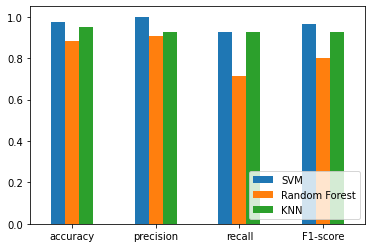

In [82]:
SVM_metrics = np.array([SVM_accuracy, SVM_precision, SVM_recall, SVM_f1_score])
RF_metrics = np.array([RF_accuracy, RF_precision, RF_recall, RF_f1_score])
KNN_metrics = np.array([KNN_accuracy, KNN_precision, KNN_recall, KNN_f1_score])


index = ['accuracy', 'precision', 'recall', 'F1-score']
df_metrics = pd.DataFrame({'SVM': SVM_metrics, 'Random Forest': RF_metrics,'KNN': KNN_metrics}, index=index)
df_metrics.plot.bar(rot=0)
plt.legend(loc="lower right")
plt.show()

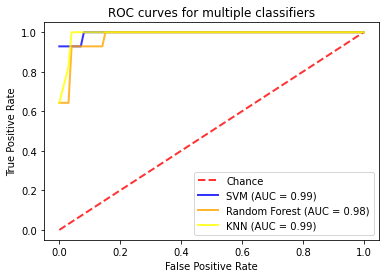

In [83]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.plot(mean_fpr, SVM_tpr[0,:], lw=2, color='blue', label='SVM (AUC = %0.2f)' % (SVM_auc), alpha=0.8)
plt.plot(mean_fpr, RF_tpr[0,:], lw=2, color='orange', label='Random Forest (AUC = %0.2f)' % (RF_auc), alpha=0.8)
plt.plot(mean_fpr, KNN_tpr[0,:], lw=2, color='yellow', label='KNN (AUC = %0.2f)' % (KNN_auc), alpha=0.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for multiple classifiers')
plt.legend(loc="lower right")
plt.show()

# Conclusion

To sum up the comaprison of the models it is clear that the SVM Classifier is the most accurate but this however is very closely followed by the KNN in this current situation.
If the code is ran again this may change however

The scores for accuracy, precision, recall and f1 score while looking at SVM and KNN were all really close while Random Forest was sligtly lacking in all areas. 

RF is the lowest scoring overall
SVM is the highest scoring and will be the model of choice

In the ROC test we can see that the models prove a to be a lot more accurate than chance. The AUC values of SVM and KNN were the same at 0.99 while RF was 0.98

# Training a final model

In [85]:
# function to remove the string 'svm__' from the names of the parameters in SVM_best_params
def transform(dict):
    return {key.replace('svm__','') :  value for key, value in dict.items()}

pipe = make_pipeline(preprocess_pipeline, svm.SVC(**transform(SVM_best_params)))

final_model =pipe.fit(X, y)